In [1]:
import os
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm

# Thư mục dữ liệu gốc và thư mục lưu spectrogram
root_dir = "nuhive_processed"       # chứa 3 folder: bee, nobee, noqueen
out_dir = "mel_spectrograms"        # folder lưu kết quả
os.makedirs(out_dir, exist_ok=True)

# MelSpectrogram 
mel_transform = MelSpectrogram(
    sample_rate=22050,
    n_mels=32,
    n_fft=2048,
    hop_length=512
)
db_transform = AmplitudeToDB()

# Tạo và lưu trữ spectrogram
label_map = {"bee": 0, "nobee": 1, "noqueen": 2}

for label_name, label_id in label_map.items():
    folder = os.path.join(root_dir, label_name)
    files = [f for f in os.listdir(folder) if f.endswith(".wav")]

    for i, fname in enumerate(tqdm(files, desc=f"Processing {label_name}")):
        filepath = os.path.join(folder, fname)

        # Độc dữ liệu âm thanh
        waveform, sr = torchaudio.load(filepath)
        if sr != 22050:
            waveform = torchaudio.functional.resample(waveform, sr, 22050)

        # Chuyển thành MelSpectrogram
        mel_spec = mel_transform(waveform)
        mel_spec_db = db_transform(mel_spec)

        
        if mel_spec_db.shape[0] > 1:
            mel_spec_db = mel_spec_db.mean(dim=0, keepdim=True)

        # Lưu file với tên gọn
        out_name = f"{label_name}_{i:04d}.pt"
        out_path = os.path.join(out_dir, out_name)

        torch.save(
            {
                "spectrogram": mel_spec_db,
                "label": label_id
            },
            out_path
        )

print("MelSpectrograms đã được lưu vào:", out_dir)


Processing noqueen: 100%|██████████| 4861/4861 [00:31<00:00, 156.58it/s]

MelSpectrograms đã được lưu vào: mel_spectrograms


In [2]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Đọc file .pt khi cần
class MelSpectrogramPTDataset(Dataset):
    def __init__(self, files, labels):
        self.files = files
        self.labels = labels

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])   # load .pt khi cần
        spectrogram = data["spectrogram"]    # (1, n_mels, time)
        label = self.labels[idx]
        return spectrogram, label

# Danh sách file + nhãn
pt_dir = "mel_spectrograms"  # nơi đã lưu bee_0001.pt, nobee_0002.pt, ...
all_files = [os.path.join(pt_dir, f) for f in os.listdir(pt_dir) if f.endswith(".pt")]

label_map = {"bee": 0, "nobee": 1, "noqueen": 2}
all_labels = []

for f in all_files:
    fname = os.path.basename(f)
    if fname.startswith("bee"):
        all_labels.append(label_map["bee"])
    elif fname.startswith("nobee"):
        all_labels.append(label_map["nobee"])
    elif fname.startswith("noqueen"):
        all_labels.append(label_map["noqueen"])

# Stratified Split
train_files, temp_files, train_labels, temp_labels = train_test_split(
    all_files, all_labels, test_size=0.30, stratify=all_labels, random_state=42
)

val_files, test_files, val_labels, test_labels = train_test_split(
    temp_files, temp_labels, test_size=0.50, stratify=temp_labels, random_state=42
)

# Tạo Dataset và DataLoader
train_dataset = MelSpectrogramPTDataset(train_files, train_labels)
val_dataset = MelSpectrogramPTDataset(val_files, val_labels)
test_dataset = MelSpectrogramPTDataset(test_files, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# Thông tin 1 batch
for X, y in train_loader:
    print("Batch X shape:", X.shape)  # (batch, 1, n_mels, time)
    print("Batch y shape:", y.shape)  # (batch,)
    break


Train: 9654, Val: 2069, Test: 2069
Batch X shape: torch.Size([16, 1, 32, 87])
Batch y shape: torch.Size([16])


Epoch 1/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 75.27it/s]


Epoch 1/30 | Train Loss: 0.6392, Train Acc: 0.7174, Train F1: 0.6667 | Val Loss: 0.4918, Val Acc: 0.7719, Val F1: 0.6669


Epoch 2/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 79.94it/s]


Epoch 2/30 | Train Loss: 0.5089, Train Acc: 0.7783, Train F1: 0.7250 | Val Loss: 0.5030, Val Acc: 0.7695, Val F1: 0.6649


Epoch 3/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 91.15it/s]


Epoch 3/30 | Train Loss: 0.4796, Train Acc: 0.7895, Train F1: 0.7353 | Val Loss: 0.4762, Val Acc: 0.7912, Val F1: 0.7473


Epoch 4/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 75.13it/s]


Epoch 4/30 | Train Loss: 0.4603, Train Acc: 0.8004, Train F1: 0.7476 | Val Loss: 0.4422, Val Acc: 0.7941, Val F1: 0.7596


Epoch 5/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 82.12it/s]


Epoch 5/30 | Train Loss: 0.4410, Train Acc: 0.8054, Train F1: 0.7551 | Val Loss: 0.4246, Val Acc: 0.8101, Val F1: 0.7389


Epoch 6/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 83.84it/s]


Epoch 6/30 | Train Loss: 0.4281, Train Acc: 0.8158, Train F1: 0.7732 | Val Loss: 0.4563, Val Acc: 0.8183, Val F1: 0.7565


Epoch 7/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 82.93it/s]


Epoch 7/30 | Train Loss: 0.4156, Train Acc: 0.8170, Train F1: 0.7714 | Val Loss: 0.4234, Val Acc: 0.8212, Val F1: 0.7877


Epoch 8/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 79.77it/s]


Epoch 8/30 | Train Loss: 0.4083, Train Acc: 0.8259, Train F1: 0.7861 | Val Loss: 0.3896, Val Acc: 0.8347, Val F1: 0.7912


Epoch 9/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 70.95it/s]


Epoch 9/30 | Train Loss: 0.3995, Train Acc: 0.8266, Train F1: 0.7864 | Val Loss: 0.4058, Val Acc: 0.8149, Val F1: 0.7793


Epoch 10/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 75.24it/s]


Epoch 10/30 | Train Loss: 0.3965, Train Acc: 0.8285, Train F1: 0.7880 | Val Loss: 0.4249, Val Acc: 0.8265, Val F1: 0.7919


Epoch 11/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 79.61it/s]


Epoch 11/30 | Train Loss: 0.3828, Train Acc: 0.8286, Train F1: 0.7911 | Val Loss: 0.4069, Val Acc: 0.8304, Val F1: 0.7907


Epoch 12/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 88.84it/s]


Epoch 12/30 | Train Loss: 0.3816, Train Acc: 0.8329, Train F1: 0.7950 | Val Loss: 0.4086, Val Acc: 0.8250, Val F1: 0.8018


Epoch 13/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 96.57it/s]


Epoch 13/30 | Train Loss: 0.3781, Train Acc: 0.8350, Train F1: 0.7989 | Val Loss: 0.3877, Val Acc: 0.8304, Val F1: 0.7976


Epoch 14/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 75.08it/s]


Epoch 14/30 | Train Loss: 0.3654, Train Acc: 0.8372, Train F1: 0.8019 | Val Loss: 0.4049, Val Acc: 0.8163, Val F1: 0.7649


Epoch 15/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 92.02it/s]


Epoch 15/30 | Train Loss: 0.3602, Train Acc: 0.8420, Train F1: 0.8099 | Val Loss: 0.3872, Val Acc: 0.8391, Val F1: 0.8050


Epoch 16/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 94.84it/s] 


Epoch 16/30 | Train Loss: 0.3512, Train Acc: 0.8463, Train F1: 0.8147 | Val Loss: 0.3857, Val Acc: 0.8352, Val F1: 0.8069


Epoch 17/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 85.24it/s]


Epoch 17/30 | Train Loss: 0.3429, Train Acc: 0.8493, Train F1: 0.8206 | Val Loss: 0.3768, Val Acc: 0.8424, Val F1: 0.8118


Epoch 18/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 82.47it/s]


Epoch 18/30 | Train Loss: 0.3329, Train Acc: 0.8528, Train F1: 0.8243 | Val Loss: 0.4075, Val Acc: 0.8337, Val F1: 0.7927


Epoch 19/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 89.64it/s]


Epoch 19/30 | Train Loss: 0.3323, Train Acc: 0.8546, Train F1: 0.8266 | Val Loss: 0.3921, Val Acc: 0.8352, Val F1: 0.8114


Epoch 20/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 86.69it/s]


Epoch 20/30 | Train Loss: 0.3192, Train Acc: 0.8589, Train F1: 0.8352 | Val Loss: 0.3777, Val Acc: 0.8449, Val F1: 0.8088


Epoch 21/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 82.61it/s]


Epoch 21/30 | Train Loss: 0.3099, Train Acc: 0.8614, Train F1: 0.8359 | Val Loss: 0.3842, Val Acc: 0.8400, Val F1: 0.8139


Epoch 22/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 89.07it/s]


Epoch 22/30 | Train Loss: 0.3083, Train Acc: 0.8642, Train F1: 0.8403 | Val Loss: 0.3935, Val Acc: 0.8439, Val F1: 0.8158


Epoch 23/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 78.51it/s]


Epoch 23/30 | Train Loss: 0.2947, Train Acc: 0.8670, Train F1: 0.8446 | Val Loss: 0.4261, Val Acc: 0.8420, Val F1: 0.8111


Epoch 24/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 83.95it/s]


Epoch 24/30 | Train Loss: 0.2884, Train Acc: 0.8700, Train F1: 0.8480 | Val Loss: 0.4027, Val Acc: 0.8458, Val F1: 0.8234


Epoch 25/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 70.27it/s]


Epoch 25/30 | Train Loss: 0.2819, Train Acc: 0.8729, Train F1: 0.8525 | Val Loss: 0.4002, Val Acc: 0.8342, Val F1: 0.8063


Epoch 26/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 78.81it/s]


Epoch 26/30 | Train Loss: 0.2730, Train Acc: 0.8748, Train F1: 0.8559 | Val Loss: 0.4325, Val Acc: 0.8357, Val F1: 0.8007


Epoch 27/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 78.92it/s]


Epoch 27/30 | Train Loss: 0.2665, Train Acc: 0.8782, Train F1: 0.8594 | Val Loss: 0.4270, Val Acc: 0.8405, Val F1: 0.8104


Epoch 28/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 79.15it/s]


Epoch 28/30 | Train Loss: 0.2617, Train Acc: 0.8806, Train F1: 0.8629 | Val Loss: 0.4556, Val Acc: 0.8347, Val F1: 0.8009


Epoch 29/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 87.31it/s]


Epoch 29/30 | Train Loss: 0.2501, Train Acc: 0.8869, Train F1: 0.8702 | Val Loss: 0.4360, Val Acc: 0.8410, Val F1: 0.8118


Epoch 30/30 [Val]: 100%|██████████| 130/130 [00:01<00:00, 77.23it/s]


Epoch 30/30 | Train Loss: 0.2399, Train Acc: 0.8912, Train F1: 0.8766 | Val Loss: 0.4804, Val Acc: 0.8250, Val F1: 0.8010


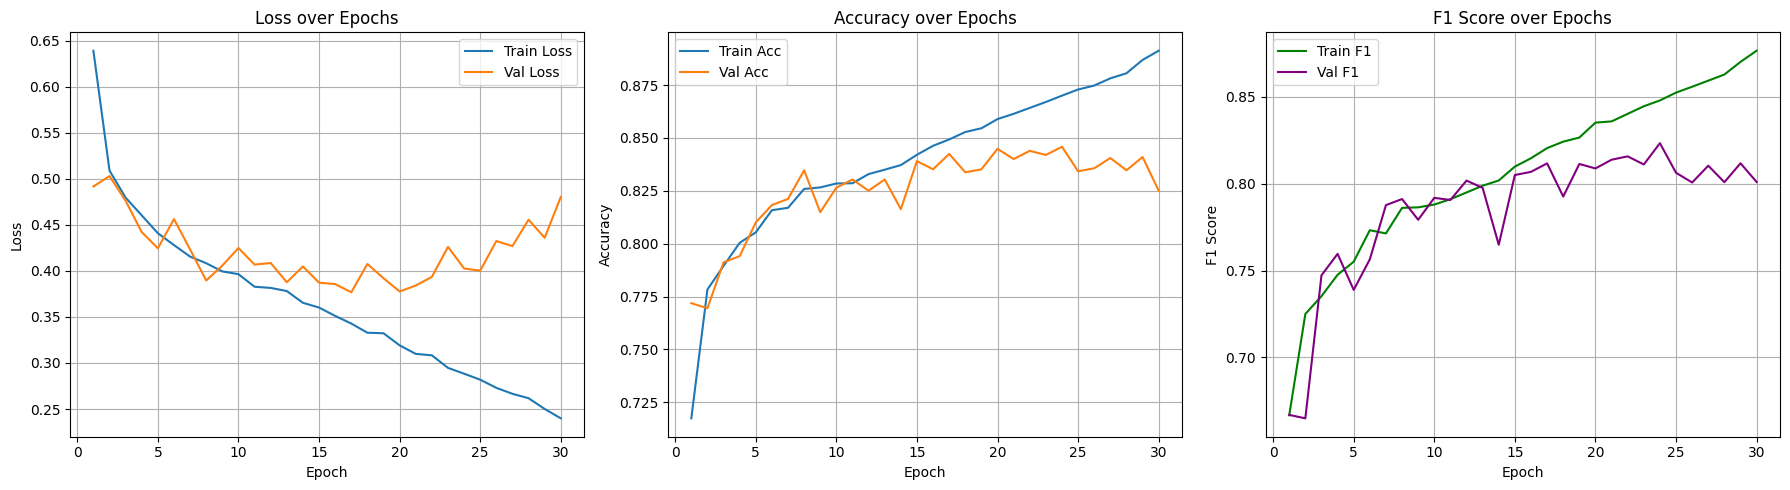

In [8]:
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, classification_report

# Định nghĩa CNN model
class AudioCNN(nn.Module):
    def __init__(self, num_classes):
        super(AudioCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Pool về 4x4 để flatten cố định
        self.pool = nn.AdaptiveAvgPool2d((4,4))
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# Khởi tạo model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 3   # bee, nobee, noqueen
model = AudioCNN(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 30
history = {
    "train_loss": [], "train_acc": [], "train_f1": [],
    "val_loss": [], "val_acc": [], "val_f1": []
}

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss, correct, total = 0, 0, 0
    train_preds, train_labels = [], []
    for X, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        X, y = X.to(device), y.to(device)

        outputs = model(X)
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        train_preds.extend(pred.cpu().numpy())
        train_labels.extend(y.cpu().numpy())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_f1 = f1_score(train_labels, train_preds, average="macro")

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)

            val_loss += loss.item()
            _, pred = torch.max(outputs, 1)
            correct += (pred == y).sum().item()
            total += y.size(0)

            val_preds.extend(pred.cpu().numpy())
            val_labels.extend(y.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_f1 = f1_score(val_labels, val_preds, average="macro")

    # Lưu kết quả epoch
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["train_f1"].append(train_f1)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["val_f1"].append(val_f1)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

# Vẽ biểu đồ
epochs = range(1, num_epochs+1)
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Loss over Epochs"); plt.legend(); plt.grid(True)

plt.subplot(1,3,2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs"); plt.legend(); plt.grid(True)

plt.subplot(1,3,3)
plt.plot(epochs, history["train_f1"], label="Train F1", color="green")
plt.plot(epochs, history["val_f1"], label="Val F1", color="purple")
plt.xlabel("Epoch"); plt.ylabel("F1 Score")
plt.title("F1 Score over Epochs"); plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for X, y in tqdm(test_loader, desc="Testing"):
        X, y = X.to(device), y.to(device)
        outputs = model(X)
        _, pred = torch.max(outputs, 1)
        correct += (pred == y).sum().item()
        total += y.size(0)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_acc = correct / total
test_f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Test Accuracy: {test_acc:.4f}, Test F1: {test_f1:.4f}")
print("\nClassification Report:\n",
      classification_report(all_labels, all_preds, target_names=["bee","nobee","noqueen"]))

Testing: 100%|██████████| 130/130 [00:01<00:00, 74.70it/s]

Test Accuracy: 0.8308, Test F1: 0.8078

Classification Report:
               precision    recall  f1-score   support

         bee       0.87      0.92      0.89       821
       nobee       0.68      0.62      0.65       519
     noqueen       0.88      0.88      0.88       729

    accuracy                           0.83      2069
   macro avg       0.81      0.81      0.81      2069
weighted avg       0.83      0.83      0.83      2069

